# TfidfVectorizer: how it works

In this notebook, we get acquainted with the [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from scikit learn.

In [1]:
%run notebook_utils.py

In [2]:
import sklearn 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib

# set big font in plots
SMALL_SIZE = 20
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

## TfidfVectorizer: example of creation

Here is an example of creation using the most interesting arguments for our purpose.

In [3]:
# example of vectorizer creation
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
  analyzer='char',        # character-based model
  ngram_range=(3,5),      # variable width ngrams 
  use_idf=False,          # don't ponderate tf by inverse document frequency
  sublinear_tf=False,     # don't apply log to frequences (tf: n VS tf: l)
  max_features=100,       # keep only the N most frequent ngrams 
  norm='l2'               # normalize the document-term matrix during transform
                          # (important for variable length sentences)
)

## TfidfVectorizer: sublinear_tf and norm arguments

Here, we try to better understand how the `sublinear_tf` and `norm` arguments work.


__Normalisation__ takes place after all tokens have been counter. The count vector is then _normalised_, i.e. each cell is divided by the norm $n$ of the vector. $n$ is computed using either the  _l1-norm_ or the _l2-norm_. 

The __l1 norm__ is basically summing the vector values:

$$ L1 = \sum_{i=1}^{n} |x_i| $$

The __l2 norm__ corresponds to the usual definition of the mathematical norm:

$$ L2 =  \sqrt{\sum_{i=1}^{n} x_i^2} $$


The __sublinear_tf__ happens _after normalisation_. If set, it will apply the log to each cell: $ x = 1 + log(x) $. This is often used in text processing, on the assumption that a word that appears twice as often as another is not twice as important.

In [4]:
test_sentence = "lulu " # ngrams: lu=2 ul=1 u =1

# create all possible combinations of the two arguments
options = [dict(sublinear_tf=stf, norm=n) for n in [None, 'l1', 'l2'] for stf in [False, True]]
# create one vectorizer for each combination
vecs = [(opt, TfidfVectorizer(analyzer='char', ngram_range=(2,2), use_idf=False, **opt)) for opt in options]

# use the test sentence with all combination
for opt, v in vecs:
    print("\nusing ", opt, "\n")
    res = v.fit_transform([test_sentence])
    print("\n".join(["  %s => %s" % t for t in zip(v.get_feature_names(), res.toarray()[0])]))


using  {'sublinear_tf': False, 'norm': None} 

  lu => 2.0
  u  => 1.0
  ul => 1.0

using  {'sublinear_tf': True, 'norm': None} 

  lu => 1.6931471805599454
  u  => 1.0
  ul => 1.0

using  {'sublinear_tf': False, 'norm': 'l1'} 

  lu => 0.5
  u  => 0.25
  ul => 0.25

using  {'sublinear_tf': True, 'norm': 'l1'} 

  lu => 0.45845645943177243
  u  => 0.27077177028411376
  ul => 0.27077177028411376

using  {'sublinear_tf': False, 'norm': 'l2'} 

  lu => 0.8164965809277261
  u  => 0.4082482904638631
  ul => 0.4082482904638631

using  {'sublinear_tf': True, 'norm': 'l2'} 

  lu => 0.7674945674619879
  u  => 0.4532946552278861
  ul => 0.4532946552278861


## Using TFIdfVectorizer for prediction

Now that we understand a bit better how the vectorizer works, it is time to test it as a feature extractor to predict languages. Here, we use the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) from scikit learn and don't limit the number of features.

__important__: once again, we don't preprocess/sanitize the data, so the results might not be incredible.

In [5]:
# see the script included at the beginning of the notebook
X_train, X_test, y_train, y_test = load_split_data()

TEST SET
accuracy: 0.9958

             precision    recall  f1-score   support

         de     0.9972    0.9918    0.9945      1462
         fr     0.9993    0.9986    0.9990      1468
         en     1.0000    0.9928    0.9964      1538
         it     0.9980    0.9987    0.9983      1482
         sg     0.9842    0.9972    0.9907      1438

avg / total     0.9958    0.9958    0.9958      7388



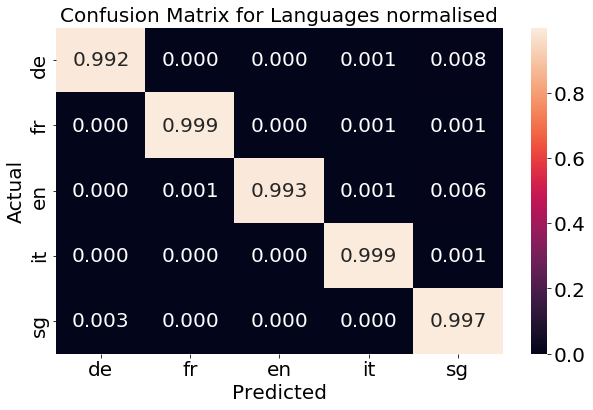



SMS RECALL
total samples    10692
total errors        28 (0.26%)
---------------------------------
languages detected
    de       26
    fr        1
    en        1
    it    10664


VALIDATION SET
accuracy: 0.8637

             precision    recall  f1-score   support

         de     1.0000    0.7264    0.8415       201
         fr     1.0000    0.9154    0.9558       201
         en     1.0000    0.7114    0.8314       201
         it     1.0000    0.9652    0.9823       201
         sg     0.5947    1.0000    0.7458       201

avg / total     0.9189    0.8637    0.8714      1005



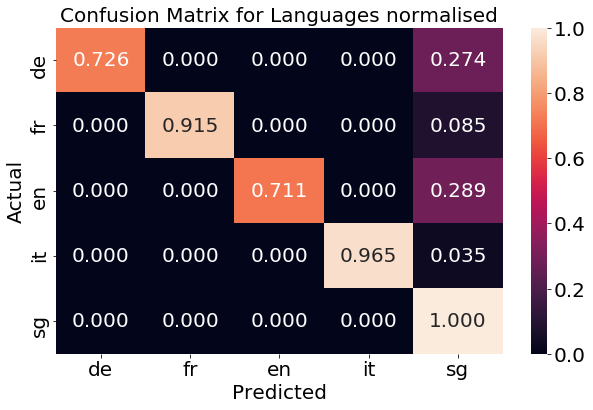

CPU times: user 28.7 s, sys: 629 ms, total: 29.3 s
Wall time: 29.3 s


In [6]:
%%time
# create and train the vectorizer
vec = TfidfVectorizer(analyzer='char',  ngram_range=(3,5))
X_fitted = vec.fit_transform(X_train, y_train)

# create and train the classifier
clf = LogisticRegression()
clf.fit(X_fitted, y_train)

# predict
y_predicted = clf.predict(vec.transform(X_test))

# show the results on the test set
print("TEST SET")
print("=========")
print_results(y_test, y_predicted)
plot_confusion_matrix(y_test, y_predicted, normalised=True)

print("\n\nSMS RECALL")
print("=========")
# show the results on the Swiss German SMS
sms_predicted = clf.predict(vec.transform(sms_sg))
eval_recall_sms(sms_predicted)

print("\n\nVALIDATION SET")
print("================")
# show the results on the validation set
X_any, y_any = load_sms_any()
any_predicted = clf.predict(vec.transform(X_any))
print_results(y_any, any_predicted)
plot_confusion_matrix(y_any, any_predicted, normalised=True)

In [12]:
print("Number of features:", len(vec.get_feature_names()))
vec.get_params()

Number of features: 628202


{'analyzer': 'char',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (3, 5),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

Note: instead of doing all the work of using the vectorizer, then the classifier, we can use the scikit [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class. Here is an example of how it works:

```python
from sklearn.pipeline import Pipeline

# create the pipeline
# you can have as many steps as you like, as long as the n-1 steps implement fit/transform and
# the last step implements fit/predict
pipe = Pipeline([
    ('vect', TfidfVectorizer(analyzer='char', ngram_range=(3,5), max_features=N)),
    ('clf', LogisticRegression())
])

# fit
pipe.fit(X_train, y_train)

# predict
y_pred = pipe.predict(X_test)
```

# Conclusion

Using the scikit vectorizer is very easy, but has a lot of parameters that need to be tuned. However, using the default options coupled with a simple logistic regression already yields promising results, at least on the test set.

Using the SMS dataset, we attain an average of 82% accuracy, with a lot of errors in predicting German and English... This is not bad, but not very good as well. 